In [190]:
import numpy as np
import pandas as pd
import datetime 
import matplotlib
import matplotlib.pyplot as plt
import re

from collections import Counter
from pprint import pprint
from nltk.corpus import stopwords
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Classification of Popular Post on Rainbow 6 Siege Subreddit

Our main steps:
1. Extract data from google Bigquery
2. Use the bag of words model (unigram, bigram) to predict popularity. We will get some insight about which words / bigrams make popular posts.
3. Use word2vec model. We can compare the accuracy, but it's hard to get insight from word2vec model. 

Some concerns that we need to watch out:
1. There are a lot of picture/video posts. We are not able to distinguish them. Here I will filter out posts with less than 25 words.
2. Reddit posts are not simple English. There are a lot of internet languages and special word in the domain. 


## Aquire Data
We used data from 2015 to 2018.2 in a Google BigQuery database: https://bigquery.cloud.google.com/dataset/fh-bigquery:reddit_posts

## Explore dataset

In [161]:
r6s = pd.read_csv('r6s_post_from_2015.csv', parse_dates= ['created_utc'])
r6s.shape

/home/fji/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (11,28,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(478460, 33)

From 2015 to 2018.2, there are 478,460 posts in [Rainbow 6 subreddit](https://www.reddit.com/r/Rainbow6/). That's huge, let's subset 3 months' posts (2017.12 - 2018.2) because we care more about recent popular posts. There are 33 columns, and we will only keep the columns we need for this analysis. 

In [162]:
# choose the columns we need 
r6s = r6s[['created_utc', 'num_comments', 'score', 'title', 'selftext']]
r6s['created'] = pd.to_datetime(r6s['created_utc'],unit='s')
r6s = r6s[r6s['created']>datetime.date(2017,12,1)]

In [163]:
r6s.shape

(85138, 6)

We have 85,138 posts from 2017.12 to 2018.2. After exploring the data, we will do following steps in preprocessing:  
1. Delete `"[removed]"` , `"[deleted]"` posts. 
2. Drop the posts where their content is less than 50 words, because maybe those posts are non-text (picture, video), and will influence our model in a negative way.

In [164]:
r6s = r6s[~r6s['selftext'].isin(['[removed]','[deleted]'])]
r6s = r6s.dropna(subset=['title','selftext']) # drop when the content is null
r6s = r6s[r6s['selftext'].str.len() > 50]
r6s.shape

(29070, 6)

In [165]:
r6s.head()

,created_utc,num_comments,score,title,selftext,created
17865,1518307810,12,0,The problem that is ruining ranked multiplayer...,So let's allow people to make as many fucking ...,2018-02-11 00:10:10
17866,1518308520,9,2,"Jackal,Buck,Blackbeard or Capitão",Rank the following attackers from best to wors...,2018-02-11 00:22:00
17867,1518308758,2,0,Vigil's elite animation,He should disappear and then make his team dis...,2018-02-11 00:25:58
17868,1518309049,4,2,What Channel do we need to watch on Twitch for...,I linked my Twitch and Ubisoft account and I w...,2018-02-11 00:30:49
17870,1518309364,0,0,Fast gunfight and daily content,"Hello guys, I was brazilian pro player for San...",2018-02-11 00:36:04


In [ ]:
pandas_profiling.ProfileReport(r6s)

Following are some interesting facts we found after doing some investigation of the dataset.   
** Summary of dataset **  
1. From 2017.8 to 2018.2, after filtering, we have 29070 posts left. 
2. In `num_comments`, there are 8.6% zeros (8.6% of the posts have 0 comments). This variable is highly skewed, see histogram below.
3. In `score`, there are 23.1% zeros. (Score is upvote - downvote, so this means 23.1% of the posts in our dataset have same number of upvotes and downvotes. I assume most of them have no votes.)
4. num_comments and score are positively correlated. 

In [166]:
# correlation between score and num_comments
r6s['score'].corr(r6s['num_comments'])

0.6792174778158041

(0, 50)

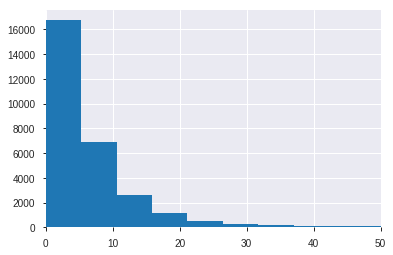

In [167]:
# histogram of num_comments
plt = r6s.num_comments.hist(bins = 1000)
plt.set_xlim(0,50)

(0, 50)

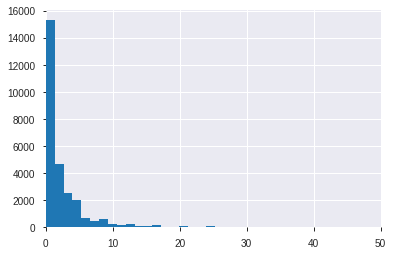

In [168]:
# histogram of score
plt = r6s.score.hist(bins = 10000)
plt.set_xlim(0,50)

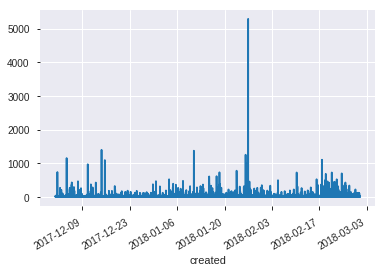

In [169]:
# num_comments along the time
r6s.groupby('created')['num_comments'].sum().plot()

In [170]:
# add response variable
r6s.num_comments.mean()

9.419539043687651

In [171]:
r6s['popular'] = r6s.num_comments>10

In [172]:
r6s['popular'].value_counts()

False    23602
True      5468
Name: popular, dtype: int64

**Choose response variable:**  
To know if a post is popular or not, we can use the number of comments or score(upvote - downvote) to calculate. 
It would be better if we can use upvote + downvote because we want to get the popular posts instead of posts that people agree with. If we use (upvote - downvote) maybe some controversial posts will have a lower score. In this sense, the number of comment might be a better proxy response for popularity. Since num_comments and score are positively correlated, so num_comment can represent some information of the score.

Here, I use a binary variable "popular" as our target variable, because it's easier to see how the model performs using classification. I set of a threshold of 10, because the mean of num_comment is 9.41, so "popular" here means have a more than average num_comments. There is a class imbalance here because our num_comments is skewed and fewer posts have more than 10 comments. Thus, for our models, we decide to:
1. use the F1 score to evaluate the classification model, also see the precision and recall for insights.
2. try different threshold in predicted probability for classification.

## Posts to word list

To tokenize words, we remove all non-letters, convert words to lower case  and split them. We removed stop words because it might be distractful for our classification. 

In [173]:
def post_to_wordlist(post_text, remove_stopwords=False):
    # remove non-letters
    post_text = re.sub("[^a-zA-Z]"," ", post_text)
    # convert words to lower case and split them
    words = post_text.lower().split()
    # remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    # return a list of words
    return(words)

post_list = [post_to_wordlist(p, remove_stopwords=True) for p in np.array(r6s.selftext)]

In [174]:
word_list = []
for post in post_list:
    for word in post:
        word_list.append(word)

In [175]:
counts = Counter(word_list)
pprint(counts.most_common(10))

[('game', 18443),
 ('like', 11263),
 ('get', 10976),
 ('would', 10079),
 ('one', 7343),
 ('play', 7190),
 ('know', 6546),
 ('team', 5963),
 ('people', 5740),
 ('time', 5494)]


Not surprising, game is the most frequent word in Rainbow6 subreddit. 

## Models
Here, we chose countvectorizer as our vectorizing technique because we want to have more insights about which words are important in classifying popular and non-popular posts. 

### Create Train and Test Dataset

In [176]:
X_train, X_test, y_train,y_test = train_test_split(post_list,
                                                   np.array(r6s["popular"]),train_size=0.8,random_state=42)

In [177]:
clean_X_train = []
for i in range(0, len(X_train)):
    clean_X_train.append(" ".join(X_train[i]))

clean_X_test = []
for i in range(0, len(X_test)):
    clean_X_test.append(" ".join(X_train[i]))
    
def create_dataset_train(X):
    clean_X = []
    for i in range(0, len(X)):
        clean_X.append(" ".join(X[i]))
    vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 5000)
    data_features = vectorizer.fit_transform(clean_X)
    data_features = data_features.toarray()
    col_names = vectorizer.get_feature_names()
    return data_features, col_names, vectorizer

train_data_features, col_names, vectorizer = create_dataset_train(X_train)

def create_dataset_test(X, vectorizer):
    clean_X = []
    for i in range(0, len(X)):
        clean_X.append(" ".join(X[i]))
    data_features = vectorizer.transform(clean_X)
    data_features = data_features.toarray()
    return data_features

test_data_features = create_dataset_test(X_test, vectorizer)

In [229]:
def report_score(y_test, y_fit, threshold = 0.2, proba=True):
    if proba:
        y_fit = [p[1] > threshold for p in y_fit]
    prec = round(precision_score(y_test, y_fit),3)
    recall = round(recall_score(y_test, y_fit),3)
    f1 = round(f1_score(y_test, y_fit),3)
    print('precision:  ', prec)
    print('recall:     ', recall)
    print('f1:         ', f1)
    conf = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_fit))
    conf.columns.name = "True\Predicted"
    print(conf)

### 1. Logistic Regression

#### Base model

In [230]:
def text_classifcation(clf: Pipeline, X_train, X_test, y_train, y_test, proba = True, thres = 0.2):
    "Helper function wrapping the Pipeline."
    clf.fit(X_train, y_train) 
    if proba:
        y_fit_proba = clf.predict_proba(X_test)
        report_score(y_test, y_fit_proba, threshold = thres)
    else:
        y_fit = clf.predict(X_test)
        report_score(y_test, y_fit, proba = False)

In [231]:
lr_pipe = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('lr', LogisticRegression())])

text_classifcation(lr_pipe, clean_X_train, clean_X_test, y_train, y_test, thres = 0.2)

precision:   0.182
recall:      0.353
f1:          0.241
True\Predicted     0     1
0               2970  1743
1                712   389


#### Parameter Tuning

In [181]:
# Since LR doesn't take too long time to fit, we use a grid search to find optimal parameters. 

parameters_lr = {'vect__ngram_range': [(1, 1), (1, 2)],
                 'vect__min_df': (1e-5, 1e-4, 1e-3, 1e-2, 1e-1),
                 'vect__stop_words': (None, 'english'),
                 'tfidf__use_idf': (True, False),
                 'lr__penalty': ['l1', 'l2'],
                 'lr__C': [1.0, 10.0, 100.0]
}

lr_grid = GridSearchCV(lr_pipe, parameters_lr, n_jobs=-1)

lr_grid.fit(clean_X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__ngram_range': [(1, 1), (1, 2)], 'vect__min_df': (1e-05, 0.0001, 0.001, 0.01, 0.1), 'vect__stop_words': (None, 'english'), 'tfidf__use_idf': (True, False), 'lr__penalty': ['l1', 'l2'], 'lr__C': [1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [212]:
lr_grid.best_params_

{'lr__C': 1.0,
 'lr__penalty': 'l2',
 'tfidf__use_idf': True,
 'vect__min_df': 0.0001,
 'vect__ngram_range': (1, 1),
 'vect__stop_words': None}

In [213]:
y_fit = lr_grid.predict_proba(clean_X_test)
report_score(y_test, y_fit, threshold = 0.20, proba=True)

precision:   0.183
recall:      0.357
f1:          0.242
True\Predicted     0     1
0               2954  1759
1                708   393


After tuning parameter, F1 score increased a little bit. It's still not very good though. 

#### PR Curve

In [192]:
def p_r_curve(y_true, y_fit):
    precision, recall, _ = metrics.precision_recall_curve(y_true, y_fit)
    plt.step(recall, precision, color='b', alpha=0.8,
             where='post')
    plt.axhline(y=0.064, ls='--', alpha=0.8)
    plt.grid()
    plt.xlabel('recall')
    plt.ylabel('precision')

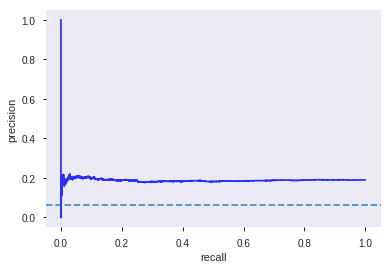

In [193]:
p_r_curve(y_test, y_fit[:,1])

The PR curve seems unstable and shows that the logistic model is not very promising here.

### 2. Random Forest Model

#### Base Model

In [232]:
rf = RandomForestClassifier(n_estimators = 10)
rf = rf.fit(train_data_features, y_train)

In [233]:
y_fit_proba = rf.predict_proba(test_data_features)

In [234]:
report_score(y_test, y_fit_proba, 0.3)

precision:   0.315
recall:      0.277
f1:          0.295
True\Predicted     0    1
0               4050  663
1                796  305


The baseline model seems better than logistic regression. Let's do some parameter tuning :)

#### Parameter Tuning

In [ ]:
# here, we use a randomized search because RF takes a long time to fit. 

# parameter tuning
param_dist = {"max_features": [0.3,0.7,None],
             "min_samples_leaf": [1,5,10,25],
             "n_estimators": [10, 50, 100]}

# run randomized search
n_iter_search = 10 
rf = RandomForestClassifier()
rf_random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=n_iter_search)
rf_random_search.fit(train_data_features, y_train)

Unfortunately, above code works fine on 1 month data but took too long to run on 3 months. If I have time, I might run it on AWS. Here, I will arbitrarily chose some parameters that make sense. 

In [235]:
rf = RandomForestClassifier(n_estimators = 50, min_samples_leaf = 3)
rf = rf.fit(train_data_features, y_train)

In [236]:
y_fit = rf.predict_proba(test_data_features)
report_score(y_test, y_fit, threshold = 0.2, proba=True)

precision:   0.275
recall:      0.598
f1:          0.377
True\Predicted     0     1
0               2980  1733
1                443   658


This seems much better. Precision is a little bit low but it is not too bad. Let's see what are the most important words in this RF model.

#### PR Curve

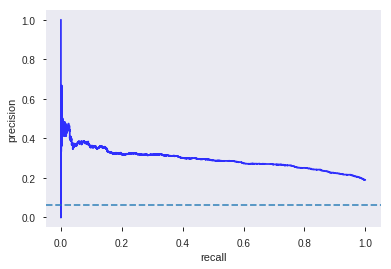

In [274]:
p_r_curve(y_test, y_fit[:,1])

This looks much better than the logistic regression model. 

#### Intepret

In [242]:
fi = pd.DataFrame({'cols':col_names, 'imp':rf.feature_importances_})
fi = fi.sort_values('imp', ascending =False)[:15]
fi

,cols,imp
1380,edit,0.009468
4449,think,0.008569
2998,operator,0.006630
2511,like,0.005861
554,buff,0.005852
3135,people,0.005850
1816,game,0.005417
320,bad,0.005176
183,anyone,0.005130
2634,make,0.004992


Here are some most important words in the RF model. If I have more time, I will make some partial dependence plots to see how they influence the model. Here, I will simply calculate the popular percentage for posts contains above words for some intuition.

In [269]:
print('popular post %:', r6s.popular.mean())
print('1. popular post % for posts including "edit":', r6s[r6s['selftext'].str.contains(" edit ")].popular.mean())
print('2. popular post % for posts including "think":', r6s[r6s['selftext'].str.contains(" think ")].popular.mean())
print('3. popular post % for posts including "operator":', r6s[r6s['selftext'].str.contains(" operator ")].popular.mean())
print('4. popular post % for posts including "like":', r6s[r6s['selftext'].str.contains(" like ")].popular.mean())
print('5. popular post % for posts including "buff":', r6s[r6s['selftext'].str.contains(" buff ")].popular.mean())

popular post %: 0.18809769521843825
1. popular post % for posts including "edit": 0.10526315789473684
2. popular post % for posts including "think": 0.2690177790731565
3. popular post % for posts including "operator": 0.2694672131147541
4. popular post % for posts including "like": 0.22811291015904858
5. popular post % for posts including "buff": 0.3794392523364486


Here are some interesting things I noticed after investigating the posts with above words:
1. Originally, I thought "edit" is important because usually, the author will edit the posts after there are some controversial comments, which might be a kind of data leakage because the poster won't edit the post to respond to some comments before its getting popular. However, according to above data, posts with "edit" has the less popular percentage.  
2. The reason "buff" is important may indicate that players love to use and discuss buff. Buff is a term used in some video games to describe tools that increase in the power of a game element. We can also see "nerf" in the most important features, which means the decrease in power. Introducing new buff/nerf into the game and carefully designing the buff might be important for the product team. 
3. "Operator", or the character in the game is also an important term in the players' discussion. Rainbow 6 has several dozens of operators with varied gadget, armour, and speed. Players might be passionate about discussing how different operators perform in the game. 

### 3. Gradient Boosting 

In [271]:
gb = GradientBoostingClassifier(n_estimators=10)
gb.fit(train_data_features, y_train)
y_fit_proba = gb.predict_proba(test_data_features)

In [272]:
report_score(y_test, y_fit_proba, 0.2)

precision:   0.292
recall:      0.316
f1:          0.304
True\Predicted     0    1
0               3869  844
1                753  348


This looks similar to RF baseline. Let's try tuning the parameters.  
It takes too long to search parameters for 3 months data on gradient boosting, so I did randomized parameter search on 1 month data and get following optimal parameters:  
Parameters: {'n_estimators': 100, 'min_samples_leaf': 25, 'max_features': 0.7}

In [277]:
gb = GradientBoostingClassifier(n_estimators=100, min_samples_leaf = 25, max_features = 0.7)
gb.fit(train_data_features, y_train)
y_fit_proba = gb.predict_proba(test_data_features)
report_score(y_test, y_fit_proba, 0.2)

precision:   0.301
recall:      0.436
f1:          0.356
True\Predicted     0     1
0               3598  1115
1                621   480


#### PR Curve

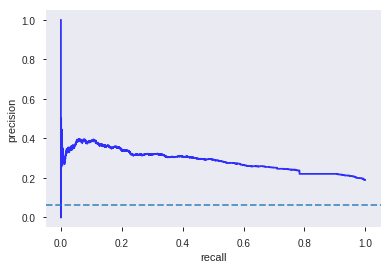

In [280]:
p_r_curve(y_test, y_fit_proba[:,1])

#### Interpret

In [278]:
fi = pd.DataFrame({'cols':col_names, 'imp':gb.feature_importances_})
fi = fi.sort_values('imp', ascending =False)[:15]
fi

,cols,imp
1380,edit,0.043679
1790,fucking,0.018078
1681,fix,0.017476
4449,think,0.015828
1816,game,0.015599
4108,spawn,0.014629
554,buff,0.013266
1610,favela,0.012882
183,anyone,0.012785
4566,tried,0.012357


In [284]:
print('popular post %:', r6s.popular.mean())
print('1. popular post % for posts including "edit":', r6s[r6s['selftext'].str.contains(" edit ")].popular.mean())
print('2. popular post % for posts including "fucking":', r6s[r6s['selftext'].str.contains(" fucking ")].popular.mean())
print('3. popular post % for posts including "fix":', r6s[r6s['selftext'].str.contains(" fix ")].popular.mean())
print('4. popular post % for posts including "favela":', r6s[r6s['selftext'].str.contains(" favela ")].popular.mean())
print('5. popular post % for posts including "spawn":', r6s[r6s['selftext'].str.contains(" spawn ")].popular.mean())

popular post %: 0.18809769521843825
1. popular post % for posts including "edit": 0.10526315789473684
2. popular post % for posts including "fucking": 0.34808853118712274
3. popular post % for posts including "fix": 0.11263972484952708
4. popular post % for posts including "favela": 0.47619047619047616
5. popular post % for posts including "spawn": 0.3463687150837989


Here are some interesting things I noticed after investigating the posts with above words:

1. The word "fucking" shows a strong emotion of author, which might be controversial - maybe a lot of people agree with him/her and disagree with him/her, and thus it generates more popular posts.
2. "Spawn" is also important here. In R6 subreddit, spawn probably appears as "Spawn peeker". This is a special term used by R6S players, meaning a player (defender) partially breaks open a window or door to get a cheap shot at the enemies. Some people think it's unfair, but it's not officially cheating, and maybe that's why it generates a lot of discussion around it. That might be something product team should look at.
3. "Favela" is a map featured in a DLC for Tom Clancy's Rainbow Six Siege. This map seems also generate a lot of discussions, and maybe marketing team can look at it for future campaigns.

### 4. Naive Bayes

In [275]:
clf = Pipeline([('vect', CountVectorizer()),
                ('clf', MultinomialNB())])

text_classifcation(clf, clean_X_train, clean_X_test, y_train, y_test)

precision:   0.184
recall:      0.229
f1:          0.204
True\Predicted     0     1
0               3599  1114
1                849   252


Since the baseline for Naive Bayes perform not so good, I decided not to tune parameter for it. 

## Winner -- Random Forest

## Future work
1. Use Word2vec as vectorizer. We chose countvectorizer as the vectorizing technique before because we want some insights, we can also try word2vec and see if it generates a higher accuracy. 
2. Create more features, for example, if the post contains a picture or video. ('is_self' column in the original dataset indicates if the post contains non-text component.)
3. Here, we use a threshold of probability to solve the class imbalance. We can also try upsampling or downsampling.
4. We can try more modeling techniques like SGD, SVM, XGBoost, etc. 